In [1]:
import os
import sys
from pdb import set_trace

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

sys.path.append('../detr/models')
sys.path.append('../detr')

In [2]:
import lerobot
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset

from lerobot.common.policies.act.configuration_act import ACTConfig
from lerobot.common.policies.normalize import Normalize, Unnormalize
from lerobot.common.datasets.utils import cycle

# Data handling using LeRobot

In [3]:
lerobot.available_datasets

['lerobot/aloha_sim_insertion_human',
 'lerobot/aloha_sim_insertion_scripted',
 'lerobot/aloha_sim_transfer_cube_human',
 'lerobot/aloha_sim_transfer_cube_scripted',
 'lerobot/pusht',
 'lerobot/xarm_lift_medium',
 'lerobot/xarm_lift_medium_replay',
 'lerobot/xarm_push_medium',
 'lerobot/xarm_push_medium_replay',
 'lerobot/aloha_mobile_cabinet',
 'lerobot/aloha_mobile_chair',
 'lerobot/aloha_mobile_elevator',
 'lerobot/aloha_mobile_shrimp',
 'lerobot/aloha_mobile_wash_pan',
 'lerobot/aloha_mobile_wipe_wine',
 'lerobot/aloha_static_battery',
 'lerobot/aloha_static_candy',
 'lerobot/aloha_static_coffee',
 'lerobot/aloha_static_coffee_new',
 'lerobot/aloha_static_cups_open',
 'lerobot/aloha_static_fork_pick_up',
 'lerobot/aloha_static_pingpong_test',
 'lerobot/aloha_static_pro_pencil',
 'lerobot/aloha_static_screw_driver',
 'lerobot/aloha_static_tape',
 'lerobot/aloha_static_thread_velcro',
 'lerobot/aloha_static_towel',
 'lerobot/aloha_static_vinh_cup',
 'lerobot/aloha_static_vinh_cup_lef

In [4]:
args = {}
args['chunk_size'] = 100

delta_timestamps = {
    "observation.images.top": [0],
    "observation.state": [0],
    "action": [t / 50 for t in range(args['chunk_size'])],  # this dataset was recorded at 50Hz
}
train_dataset = LeRobotDataset('lerobot/aloha_sim_transfer_cube_scripted', split='train[:80%]', delta_timestamps=delta_timestamps)
val_dataset = LeRobotDataset('lerobot/aloha_sim_transfer_cube_scripted', split='train[80%:]', delta_timestamps=delta_timestamps)

Fetching 56 files:   0%|          | 0/56 [00:00<?, ?it/s]

Fetching 56 files:   0%|          | 0/56 [00:00<?, ?it/s]

In [5]:
import numpy as np

ims = []
for idx in range(train_dataset.episode_data_index['to'][0]):
    image =  train_dataset[idx]['observation.images.top'].squeeze(0).permute(1,2,0)
    image = (image * 255).numpy().astype(np.uint8)
    ims.append(image)

In [6]:
ims[0].shape

(480, 640, 3)

In [7]:
import imageio
from IPython.display import Video

imageio.mimsave('output.mp4', ims, fps=50)
video = Video('output.mp4', width=320, height=240)
video

### Very handy data normalization/unnformalization functions

In [8]:
import pickle

file_path = "/home/radek/workspace/experiments/aloha/sim_transfer_cube_scripted/51/dataset_stats.pkl"

with open(file_path, "rb") as file:
    train_dataset_stats = pickle.load(file)

In [9]:
import torch

train_dataset.stats['action']['mean'] = torch.tensor(train_dataset_stats['action_mean'])
train_dataset.stats['action']['std'] = torch.tensor(train_dataset_stats['action_std'])

train_dataset.stats['observation.state']['mean'] = torch.tensor(train_dataset_stats['qpos_mean'])
train_dataset.stats['observation.state']['std'] = torch.tensor(train_dataset_stats['qpos_std'])

# using imagenet stats
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std=[0.229, 0.224, 0.225]
train_dataset.stats['observation.images.top']['mean'] = torch.tensor(imagenet_mean)[:, None, None]
train_dataset.stats['observation.images.top']['std'] = torch.tensor(imagenet_std)[:, None, None]

In [10]:
config = ACTConfig()

normalize_inputs = Normalize(
    config.input_shapes, config.input_normalization_modes, train_dataset.stats
)
normalize_targets = Normalize(
    config.output_shapes, config.output_normalization_modes, train_dataset.stats
)
unnormalize_outputs = Unnormalize(
    config.output_shapes, config.output_normalization_modes, train_dataset.stats
)

These functions can operate directly on batches and leverage stored statistics.

In [11]:
normalize_inputs.shapes

{'observation.images.top': [3, 480, 640], 'observation.state': [14]}

In [12]:
normalize_inputs.modes

{'observation.images.top': 'mean_std', 'observation.state': 'mean_std'}

In [13]:
normalize_inputs.stats['observation.images.top']['mean'].shape

torch.Size([3, 1, 1])

# Create DataLoaders

In [14]:
import torch
import multiprocessing as mp

In [15]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    num_workers=mp.cpu_count()-1,
    batch_size=8,
    shuffle=True,
    pin_memory=True,
    drop_last=False,
)

In [16]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    num_workers=mp.cpu_count()-1,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
)

In [17]:
batch = next(iter(train_dataloader))

In [18]:
for k,v in batch.items():
    print(f'{k}: {v.shape}')

observation.images.top: torch.Size([8, 1, 3, 480, 640])
observation.state: torch.Size([8, 1, 14])
action: torch.Size([8, 100, 14])
episode_index: torch.Size([8])
frame_index: torch.Size([8])
timestamp: torch.Size([8])
next.done: torch.Size([8])
index: torch.Size([8])
observation.images.top_is_pad: torch.Size([8, 1])
observation.state_is_pad: torch.Size([8, 1])
action_is_pad: torch.Size([8, 100])


# Load trained policy

In [19]:
from aim import Run
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

from transformer import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer
from transformer import Transformer as DETRTransformer
from position_encoding import PositionEmbeddingSine, PositionEmbeddingLearned, NestedTensor

In [20]:
dry_run = True

args = {
    'num_epochs': 10000,
    'eval_interval_epochs': 500,
    'num_eval_rollouts': 100,
    'lr_backbone': 1e-5,
    'batch_size': 8,
    'chunk_size': 100,  # chunk_size is --> num_queries <-- !!!!
    'd_model': 512,  # d_model
    'dim_feedforward': 3200,
    'lr': 1e-5,
    'kl_weight': 10,
    'state_dim': 14,
    'num_episodes': 50,
    'episode_len': 400,
    'camera_names': ['top'],
    'num_encoder_layers': 4,
    'num_decoder_layers': 7,
    'backbone': 'resnet18',
    'nhead': 8,
    'weight_decay': 1e-4,
    'dropout': 0.1,
    'position_embedding': 'sine',
    'normalize_before': False,
    'fps': 50,
    'latent_dim': 32,
    'inference_query_frequency': 20
}

if dry_run:
    args.update({
        'num_epochs': 2,
        'num_eval_rollouts': 2,
    })

run = Run(experiment="imitate_episodes", repo='dry_run' if dry_run else None)
run["hparams"] = args['chunk_size']

In [21]:
%run define_arch.ipynb

In [22]:
len(train_dataset), len(val_dataset)

(16000, 4000)

In [23]:
run = Run(experiment="imitate_episodes", repo='dry_run' if dry_run else None)
run["hparams"] = args

In [24]:
# useful for figuring out how long cycling through the batches of an entire dataset takes, but probably for training I'll use cycle

# %%time
# for i, batch in enumerate(train_dataloader):
#     pass

In [25]:
policy = ACTPolicy()

print(f"KL Weight {args['kl_weight']}")

n_parameters = sum(p.numel() for p in policy.model.parameters() if p.requires_grad)
print("number of parameters: %.2fM" % (n_parameters/1e6))

KL Weight 10
number of parameters: 83.93M


/home/radek/miniforge3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/radek/miniforge3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
policy.model.cuda()

# ACTPolicy returns the loss if passed actions, otherwise predicts actions, operates on "chunk" of actions, potentially padded
policy(
    batch['observation.state'].squeeze(1).cuda(),
    image=batch['observation.images.top'].squeeze(1).cuda(),
    actions=batch['action'].cuda(),
    is_pad=batch['action_is_pad'].cuda()
)

tensor(72.3687, device='cuda:0', grad_fn=<AddBackward0>)

# Setup gym env

In [27]:
# pip install gym-aloha

In [28]:
import gymnasium as gym
import gym_aloha

env = gym.make(
    "gym_aloha/AlohaTransferCube-v0",
    obs_type="pixels_agent_pos",
    max_episode_steps=500
)
observation, info = env.reset()
frames = []
frames.append(env.render())

In [29]:
# env.render() doesnt' do anything fancy
np.allclose(frames[0], observation['pixels']['top'])

True

In [30]:
observation['pixels']['top'].dtype

dtype('uint8')

Two ways to display an image without `matplotlib`.

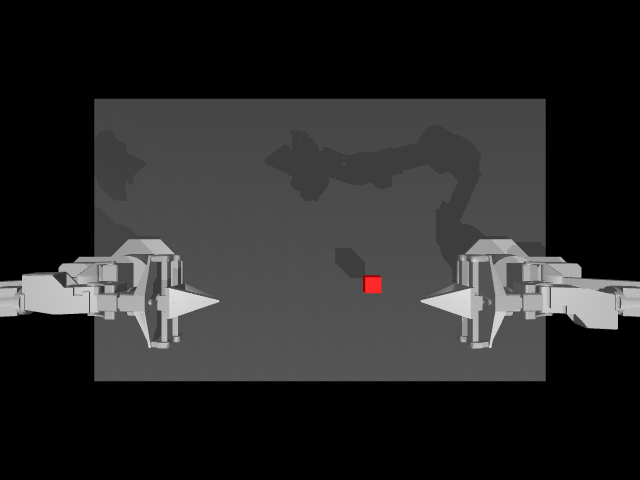

In [31]:
from IPython.display import Image

imageio.imwrite('output.png', observation['pixels']['top'])
image = imageio.v3.imread('output.png')

Image(filename='output.png')

if we reset the env, hopefully we will get a different image

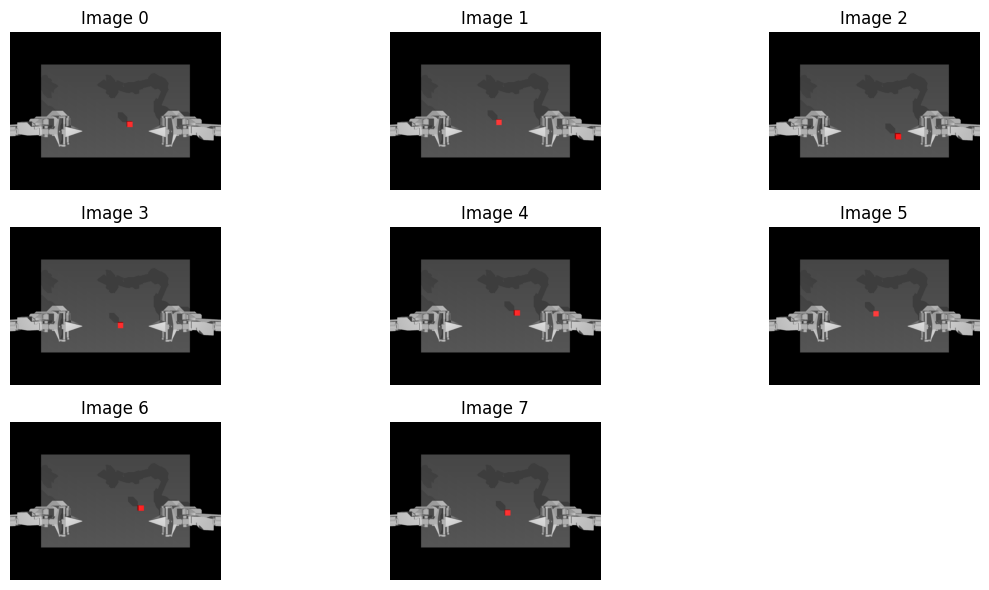

In [32]:
import numpy as np
import matplotlib.pyplot as plt


images = []
for i in range(8):
    observation, info = env.reset()
    images.append(observation['pixels']['top'])

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.set_title(f"Image {i}")
        ax.axis("off")
    else:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()

Great! sampling of the starting position works :)

In [33]:
# model trained using Action_Chunking_Transformer.ipynb!

policy.load_state_dict(
    torch.load('/home/radek/workspace/experiments/aloha/sim_transfer_cube_scripted/second_workstream/policy_epoch_9999.ckpt')
)

<All keys matched successfully>

# Drive the arms using `policy` and generate recording

In [34]:
# https://github.com/huggingface/lerobot/blob/main/examples/2_evaluate_pretrained_policy.py

from collections import deque
action_sequence = deque()

rewards = []
frames = []

numpy_observation, info = env.reset()
frames.append(env.render())

done = False
while not done:
    # Prepare observation for the policy running in Pytorch
    state = torch.from_numpy(numpy_observation["agent_pos"])  # pos, generalized position, is interchangeably referred to as "state"
    image = torch.from_numpy(numpy_observation["pixels"]["top"])

    # Convert to float32 with image from channel first in [0,255]
    # to channel last in [0,1]
    state = state.to(torch.float32)
    image = image.to(torch.float32) / 255
    image = image.permute(2, 0, 1)
    
    normalized_inputs = normalize_inputs({'observation.images.top': image, 'observation.state': state})
    state, image = normalized_inputs['observation.state'], normalized_inputs['observation.images.top']
    state = state.cuda(non_blocking=True)
    image = image.cuda(non_blocking=True)

    if not action_sequence:
        with torch.inference_mode():
            actions = policy(state.unsqueeze(0), image.unsqueeze(0))
        for action in actions.squeeze(0).to("cpu").numpy()[:args['inference_query_frequency']]:
            action_sequence.append(action)

    action = action_sequence.popleft()
    action = unnormalize_outputs({'action': torch.tensor(action)})['action'].numpy()
    numpy_observation, reward, terminated, truncated, info = env.step(action)

    rewards.append(reward)
    frames.append(env.render())

    done = terminated | truncated | done

print(f'{np.sum(rewards)=}\t{info}')

np.sum(rewards)=231	{'is_success': True}


In [35]:
video_path =  "rollout.mp4"
imageio.mimsave(str(video_path), np.stack(frames), fps=args['fps'])

print(f"Video of the evaluation is available in '{video_path}'.")

Video of the evaluation is available in 'rollout.mp4'.


In [36]:
video = Video('rollout.mp4', width=320, height=240)
video

# Calculate the loss on a validation set

In [37]:
# https://github.com/huggingface/lerobot/blob/main/examples/2_evaluate_pretrained_policy.py

policy.model.eval()

cum_loss = 0
n = 0
for batch in val_dataloader:
    normalized_inputs = normalize_inputs(batch)
    normalized_inputs = normalize_targets(normalized_inputs)
    
    states, images, actions, is_pad = (
        normalized_inputs['observation.state'].cuda(),
        normalized_inputs['observation.images.top'].cuda(),
        normalized_inputs['action'].cuda(),
        normalized_inputs['action_is_pad'].cuda()
    )

    with torch.inference_mode():
        loss = policy(states.squeeze(1), images.squeeze(1), actions, is_pad)

    current_batch_size = batch['index'].shape[0]
    cum_loss += loss.item() * current_batch_size
    n += current_batch_size

print(f'Mean loss: {cum_loss/n=}')

Mean loss: cum_loss/n=0.021410204481333493
